In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of randomised classical shadow on the ground state energy of molecules.

Procedure:
1. Choose a variational ansatz with initial parameters selected at random.
2. Generate a set of random basis change operators.
3. Apply the random operators to change bases in the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 

Note: predicting_quantum_properties module comes from https://github.com/hsinyuan-huang/predicting-quantum-properties
'''

import numpy as np
import time
import matplotlib.pyplot as plt

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.optimizers import SLSQP

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.circuit.library import EfficientSU2

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import randomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp




# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


-0.8105479805373234 * IIII
+ 0.1721839326191557 * IIIZ
- 0.2257534922240249 * IIZZ
+ 0.1721839326191554 * IZII
- 0.22575349222402488 * ZZZI
+ 0.1209126326177664 * IIZI
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print(hamiltonian_terms)
print(weights)




'''
Reformatting the Hamiltonian for use in estimate_exp(): removing all entries with Pauli I. 
'''

hamiltonian_terms_XYZ = []

for term in hamiltonian_terms:
    term_XYZ = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZ.append(pauli)
    hamiltonian_terms_XYZ.append(term_XYZ)         
    
print(hamiltonian_terms_XYZ)

[[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
[-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
[[], [('Z', 3)], [('Z', 2), ('Z', 3)], [('Z', 1)], [('Z',

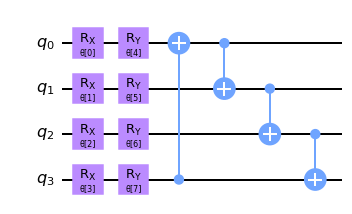

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=True)

    
ansatz.decompose().draw('mpl')

In [4]:
'''
Generate a random basis change scheme for the ansatz. 
Number of measurements set to 1000, as required by the experiment in https://arxiv.org/abs/2103.07510.
Only generate the random measurements once and use them in all VQE iterations.
'''

num_measurements = 1000 

basis_change_scheme = randomized_classical_shadow(num_measurements, system_size)
print('Randomized basis change scheme:\n', basis_change_scheme)

Randomized basis change scheme:
 [['Z', 'Z', 'Y', 'Z'], ['X', 'Z', 'Z', 'Y'], ['Y', 'Y', 'Z', 'Y'], ['X', 'Z', 'X', 'X'], ['Z', 'X', 'Y', 'Y'], ['Z', 'X', 'X', 'Z'], ['X', 'Y', 'Z', 'X'], ['Y', 'Z', 'Z', 'X'], ['X', 'Z', 'X', 'Z'], ['Y', 'Y', 'X', 'Z'], ['X', 'X', 'Z', 'Y'], ['Z', 'Z', 'X', 'Z'], ['Z', 'Z', 'Y', 'X'], ['X', 'Y', 'Z', 'X'], ['Y', 'Y', 'Y', 'Z'], ['Y', 'Z', 'Y', 'Z'], ['X', 'X', 'Y', 'Y'], ['Y', 'Y', 'Z', 'X'], ['X', 'Z', 'Y', 'X'], ['Z', 'Z', 'Z', 'Y'], ['Z', 'Z', 'Z', 'Z'], ['Z', 'X', 'X', 'Y'], ['Y', 'Y', 'Y', 'X'], ['X', 'Z', 'Z', 'Z'], ['Y', 'Z', 'Z', 'X'], ['Z', 'Y', 'X', 'X'], ['Z', 'Y', 'X', 'Y'], ['X', 'Z', 'Y', 'X'], ['X', 'Y', 'Z', 'Y'], ['Z', 'X', 'X', 'Y'], ['Y', 'Y', 'Z', 'Y'], ['Z', 'Z', 'Z', 'X'], ['Z', 'X', 'Y', 'Y'], ['Y', 'Y', 'X', 'Y'], ['X', 'Y', 'Z', 'X'], ['Y', 'X', 'Z', 'X'], ['X', 'Y', 'Y', 'X'], ['Y', 'Y', 'X', 'Z'], ['Y', 'X', 'Y', 'Z'], ['Z', 'Z', 'Y', 'Y'], ['Y', 'Y', 'Z', 'Y'], ['Z', 'Z', 'X', 'Y'], ['Z', 'X', 'Y', 'X'], ['Y', 'Y', 'Z', 'X']

In [5]:
'''
Define the cost function
'''

    
backend = QasmSimulator(method='statevector', shots=1)

# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas


def objective_function(params):
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis
    
    # Putting repeated operators in the classical shadow together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    from collections import Counter
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in basis_change_scheme)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # We perform one single shot => index(1)
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
        
      
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I occurrences removed
    # cost = the total expectation value of the Hamiltonian in the present run
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)
            
        
    cost_history.append(cost)
    
            
    return cost


In [6]:
'''
Classical optimisation step
'''

# Counter for the execution time
start_time = time.time()

# Classical optimizer
optimizer = SLSQP(maxiter=500)   

# Collect the expectation value from each experiment
expectation_values = []

for _ in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(min(cost_history))
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))

elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

GROUND STATE ENERGY FOUND =  -1.4222388715605128
GROUND STATE ENERGY FOUND =  -1.3293153110405047
GROUND STATE ENERGY FOUND =  -1.3242975908040138
GROUND STATE ENERGY FOUND =  -1.353141920778183
GROUND STATE ENERGY FOUND =  -1.301047027549813
GROUND STATE ENERGY FOUND =  -1.3452761420864963
GROUND STATE ENERGY FOUND =  -1.3033636653013552
GROUND STATE ENERGY FOUND =  -1.4049379273554319
GROUND STATE ENERGY FOUND =  -1.4004431149401841
GROUND STATE ENERGY FOUND =  -1.291732092359482
Execution time =  01:32:44


In [7]:
'''
Calculate the error.
'''

rmse_randomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                     for i in range(num_experiments)])/num_experiments)
print(f"The average root-mean-squared error for regular classical shadow: {rmse_randomised_cs}")


The average root-mean-squared error for regular classical shadow: 0.5143499536504353


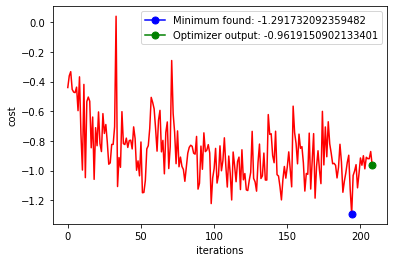

In [8]:
import matplotlib.pyplot as plt
num_points = len(cost_history)
        
min_energy = min(cost_history)
min_energy_idx = cost_history.index(min_energy)

plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
plt.plot(min_energy_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum found: '+ minimum_str)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.legend(loc=1)